# Comparing Tikhonet and SCORE

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [2]:
import os

#set cuda to run on CPU so VRAM is not an issue
#otherwise during loading model you get failed to get cuddn thing to load
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Get the current working directory
current_directory = os.getcwd()

# Print it
print("Current working directory:", current_directory)

#check tf version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.set_random_seed(2)
#check keras version
print(tf.keras.__version__)

#check python version
import sys
print(sys.version)

Current working directory: /home/acoundexist/Desktop/ShapeNetL1/evaluation
TensorFlow version: 1.15.0
2.2.4-tf
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]


In [12]:
%matplotlib inline
import sys

data_path = '/home/data_dir_optical/'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import pickle

In [13]:
f = open(data_path+"cfht_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [14]:
data.keys(),data['flux'].keys()

(dict_keys(['flux', 'mse', 'mse_w', 'mom', 'windows', 'window_flags', 'mag_auto']),
 dict_keys(['tikhonet', 'tikhonet_sc', 'SUNet', 'true']))

### Load data and compute errors

In [15]:
# load windows and flags
windows = data['windows']
window_flags = data['window_flags']

# load adaptive moments
mom_g0 = data['mom']['tikhonet']
mom_g05 = data['mom']['tikhonet_sc']
mom_SUNet = data['mom']['SUNet']
mom_hst = data['mom']['true']

# load flux
flux_g0 = data['flux']['tikhonet']
flux_g05 = data['flux']['tikhonet_sc']
flux_SUNet = data['flux']['SUNet']
flux_true = data['flux']['true']

# compute relative pixel errors
mse_g0 = data['mse']['tikhonet']
mse_g05 = data['mse']['tikhonet_sc']
mse_SUNet = data['mse']['SUNet']

# compute winodwed pixel relative errors
mse_g0_w = data['mse_w']['tikhonet']
mse_g05_w = data['mse_w']['tikhonet_sc']
mse_SUNet_w = data['mse_w']['SUNet']

# compute adapative moments errors
mom_err_g0 = np.abs(mom_g0-mom_hst)
mom_err_g05 = np.abs(mom_g05-mom_hst)
mom_err_SUNet = np.abs(mom_SUNet-mom_hst)

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true
flux_err_SUNet = np.abs(flux_SUNet - flux_true) /flux_true

### Compute Errors per Bin

In [36]:
label_s0 = r'SRA'
label_s1 = r'SCORE'
label_g0 = r'ShapeNet L1 Gamma=0.0078125'
label_g05 = r'ShapeNet L2'
label_SUNet = r'SUNet'

color_g0 = 'green'
color_g05 = 'darkgreen'
color_s0 = 'blue'
color_s1 = 'darkblue'
color_SUNet = 'red'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [37]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.359375


### Computing Errors

In [38]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_g05_win = mse_g05[window_flags]
mse_SUNet_win = mse_SUNet[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]
mse_SUNet_win_w = mse_SUNet_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]
mom_err_SUNet_win = mom_err_SUNet[:,window_flags]

# compute fluxipticity errors
flux_err_g0_win = flux_err_g0[window_flags]
flux_err_g05_win = flux_err_g05[window_flags]
flux_err_SUNet_win = flux_err_SUNet[window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(data['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_g05 = []
mom_mean_SUNet = []

mom_std_g0 = []
mom_std_g05 = []
mom_std_SUNet = []

# computing mean and standard deviation of fluxipticity error per binned magnitude

flux_mean_g0 = []
flux_mean_g05 = []
flux_mean_SUNet = []

flux_std_g0 = []
flux_std_g05 = []
flux_std_SUNet = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_g05 = []
mse_mean_SUNet = []

mse_std_g0 = []
mse_std_g05 = []
mse_std_SUNet = []

mse_mean_g0_w = []
mse_mean_g05_w = []
mse_mean_SUNet_w = []

mse_std_g0_w = []
mse_std_g05_w = []
mse_std_SUNet_w = []

for i in range(n_bins-1):
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(data['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    mom_mean_SUNet += [np.mean(np.abs(mom_err_SUNet_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    mom_std_SUNet += [np.std(np.abs(mom_err_SUNet_win[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
    flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]
    flux_mean_SUNet += [np.mean(np.abs(flux_err_SUNet_win[ind]))]

    flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
    flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]
    flux_std_SUNet += [np.std(np.abs(flux_err_SUNet_win[ind]))]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]
    mse_mean_SUNet += [np.mean(mse_SUNet_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    mse_std_SUNet += [np.std(mse_SUNet_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]
    mse_mean_SUNet_w += [np.mean(mse_SUNet_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    mse_std_SUNet_w += [np.std(mse_SUNet_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=data['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]
mom_mean_SUNet += [np.mean(np.abs(mom_err_SUNet_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
mom_std_SUNet += [np.std(np.abs(mom_err_SUNet_win[:,ind]),axis=1)]

flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]
flux_mean_SUNet += [np.mean(np.abs(flux_err_SUNet_win[ind]))]

flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]
flux_std_SUNet += [np.std(np.abs(flux_err_SUNet_win[ind]))]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]
mse_mean_SUNet += [np.mean(mse_SUNet_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]
mse_std_SUNet += [np.std(mse_SUNet_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]
mse_mean_SUNet_w += [np.mean(mse_SUNet_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
mse_std_SUNet_w += [np.std(mse_SUNet_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g05 = np.array(mom_mean_g05).T
mom_mean_SUNet = np.array(mom_mean_SUNet).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g05 = np.array(mom_std_g05).T
mom_std_SUNet = np.array(mom_std_SUNet).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_g05 = np.array(flux_mean_g05).T
flux_mean_SUNet = np.array(flux_mean_SUNet).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_g05 = np.array(flux_std_g05).T
flux_std_SUNet = np.array(flux_std_SUNet).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g05 = np.array(mse_mean_g05).T
mse_mean_SUNet = np.array(mse_mean_SUNet).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g05 = np.array(mse_std_g05).T
mse_std_SUNet = np.array(mse_std_SUNet).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T
mse_mean_SUNet_w = np.array(mse_mean_SUNet_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T
mse_std_SUNet_w = np.array(mse_std_SUNet_w).T

In [39]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(data['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = data['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=data['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = data['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.59463357925415 20.643326
2 22.502554893493652 22.095583
3 23.00765323638916 22.766497
3 23.00765323638916 23.261372


### Plot relative flux vs $\text{MAG}$

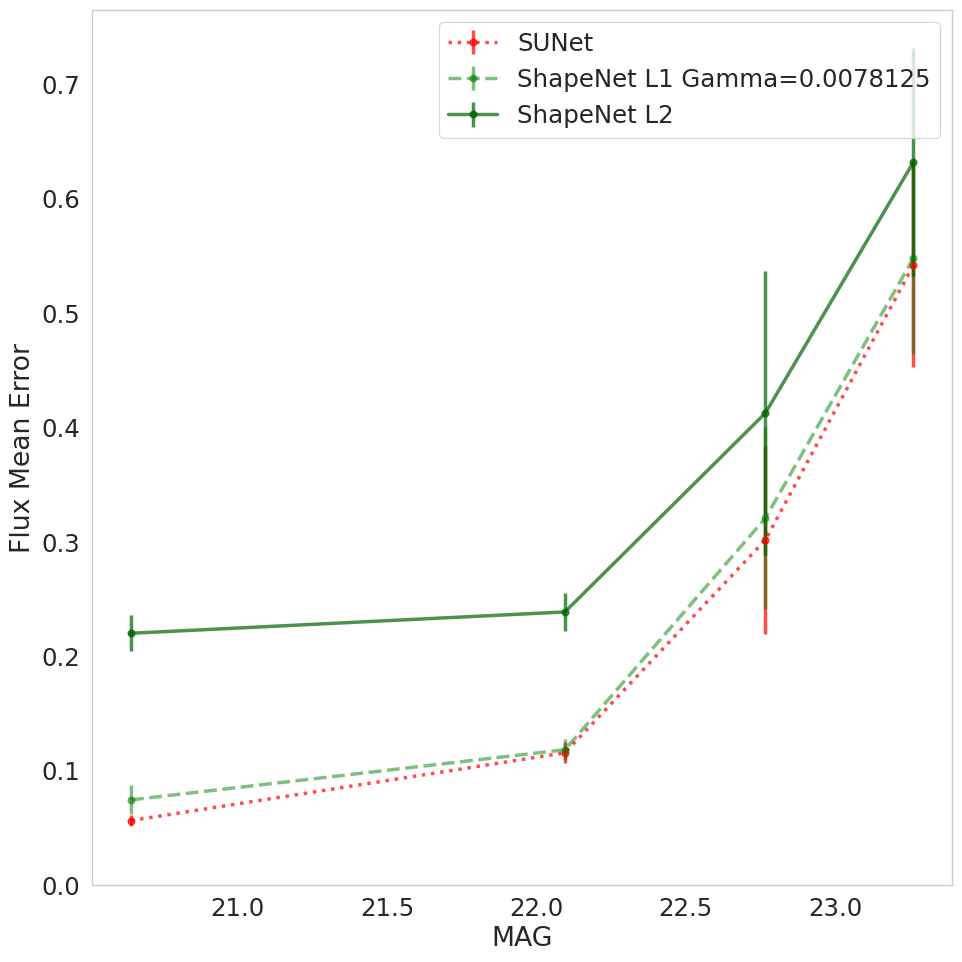

In [40]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
#remove grid from images
sns.set_style("whitegrid")#, {'axes.grid' : False})

plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_SUNet,flux_std_SUNet/sqrt_num_gal,linestyle=':', marker='o',color=color_SUNet,label=label_SUNet,alpha=0.7)
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.xlabel(r'MAG')
plt.ylabel(r'Flux Mean Error')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.savefig('./cfht_flux.pdf')

### Plot $g$ vs $\text{MAG}$

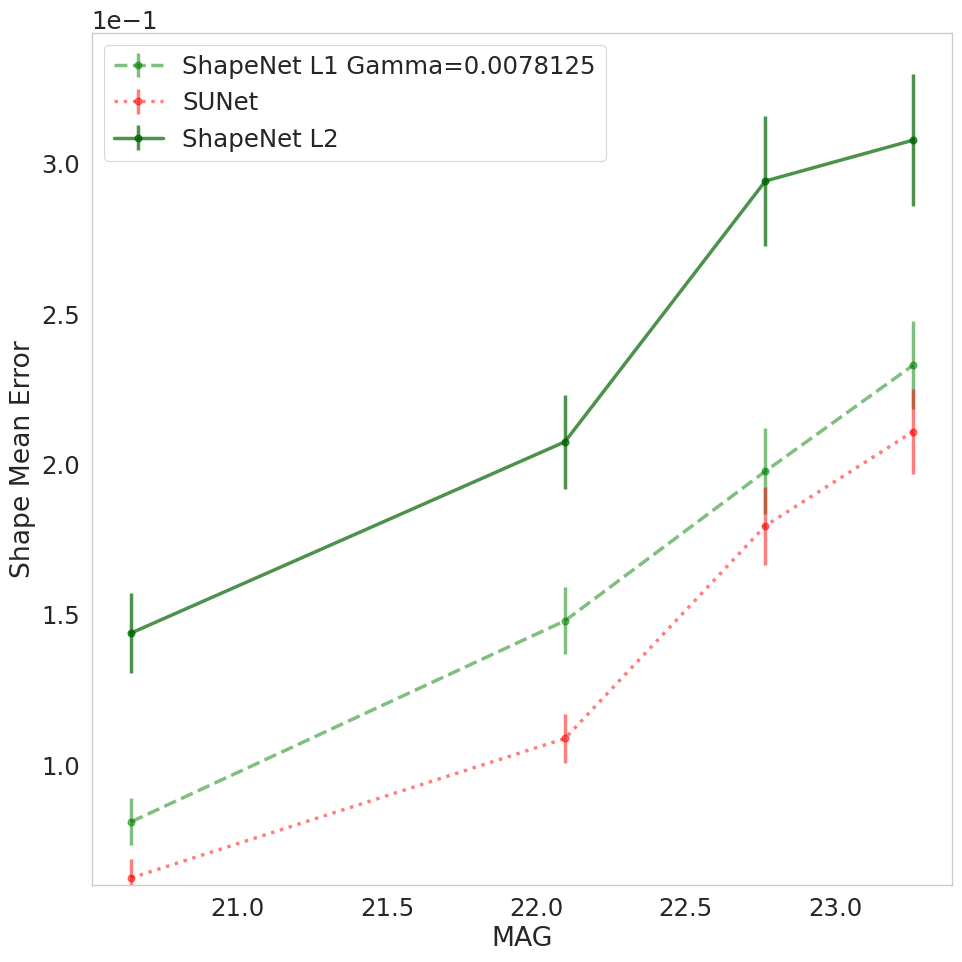

In [41]:
plt.figure(figsize=(10,10))
plt.errorbar(bins, np.sqrt(mom_mean_g0[0]**2 + mom_mean_g0[1]**2), np.sqrt(mom_std_g0[0]**2 + mom_std_g0[1]**2)/sqrt_num_gal, linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins, np.sqrt(mom_mean_SUNet[0]**2 + mom_mean_SUNet[1]**2), np.sqrt(mom_std_SUNet[0]**2 + mom_std_SUNet[1]**2)/sqrt_num_gal, linestyle=':', marker='o',color=color_SUNet,label=label_SUNet,alpha=0.5)
plt.errorbar(bins, np.sqrt(mom_mean_g05[0]**2 + mom_mean_g05[1]**2), np.sqrt(mom_std_g05[0]**2 + mom_std_g05[1]**2)/sqrt_num_gal, linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'Shape Mean Error')
plt.grid(False)
plt.legend()
y_min,y_max = plt.ylim()
y_min = 0.06
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.savefig('./cfht_e.pdf')

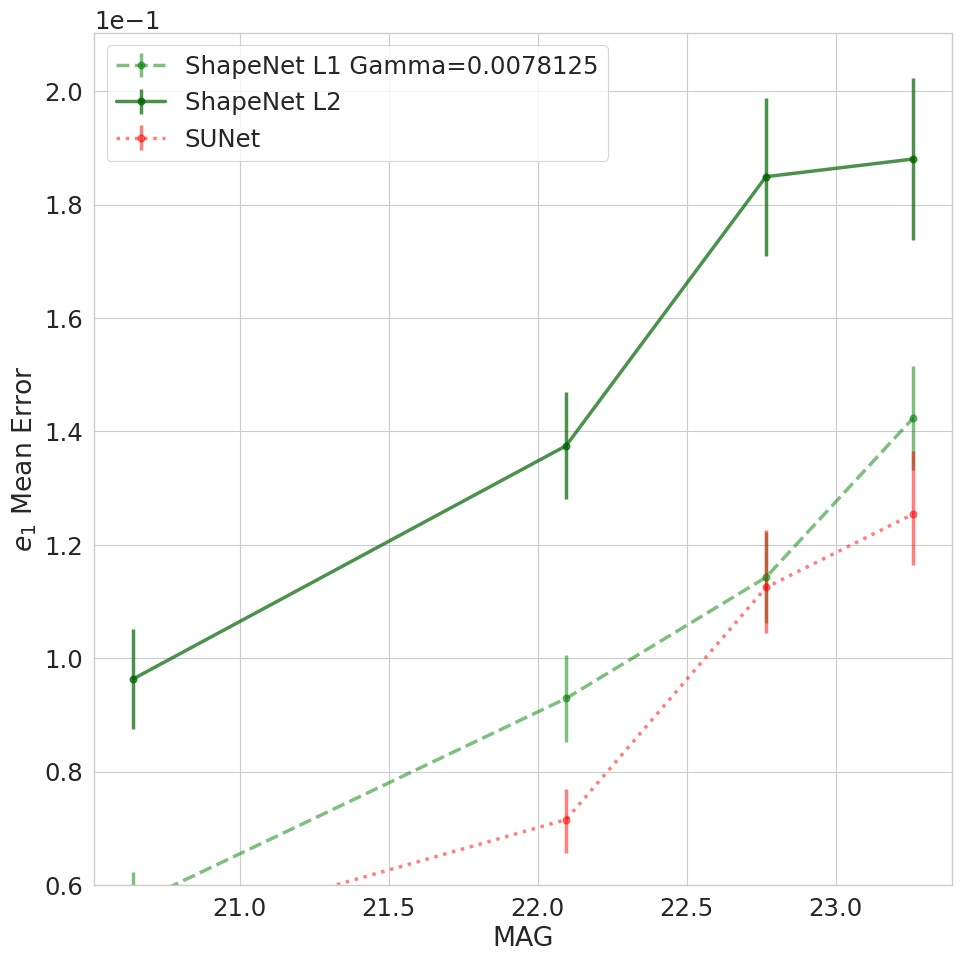

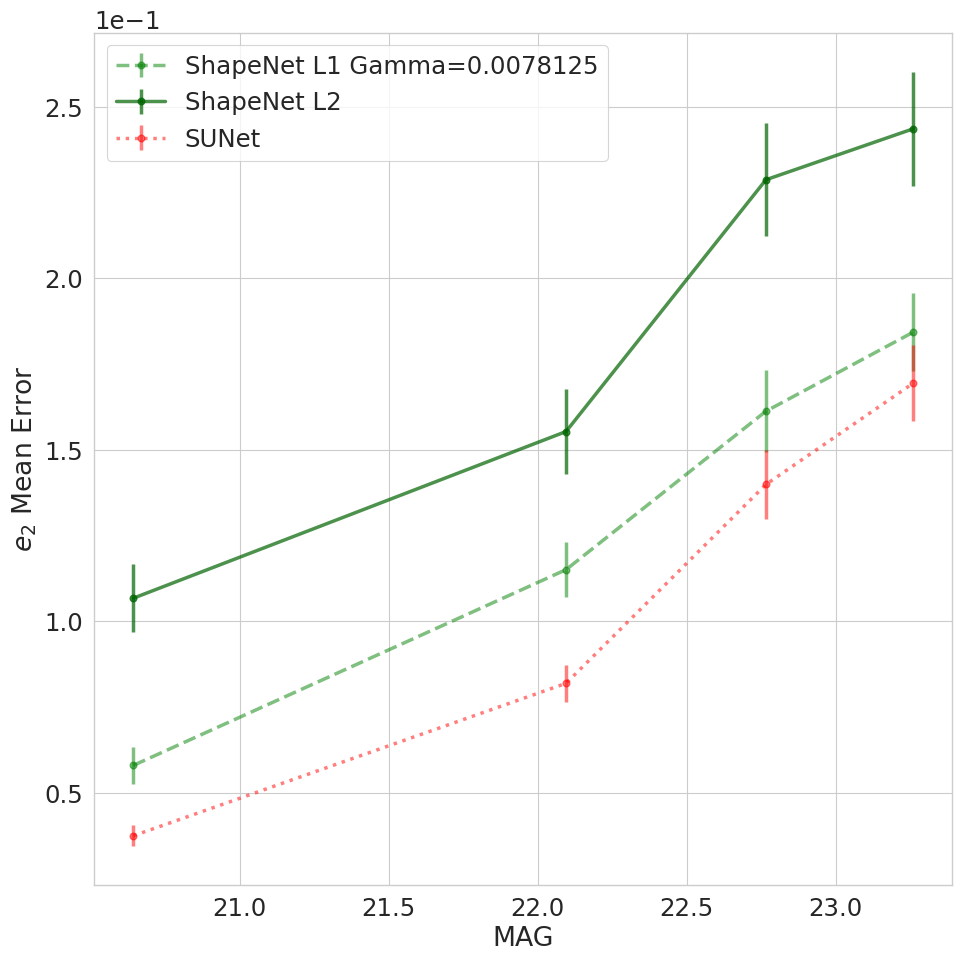

In [42]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_SUNet[0], mom_std_SUNet/sqrt_num_gal, linestyle=':', marker='o', color=color_SUNet, label=label_SUNet, alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$e_{1}$ Mean Error')
plt.legend()
y_min,y_max = plt.ylim()
y_min = 0.06
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.savefig('./cfht_e1.pdf')

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_SUNet[1], mom_std_SUNet[1]/sqrt_num_gal, linestyle=':', marker='o', color=color_SUNet, label=label_SUNet, alpha=0.5)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$e_2$ Mean Error')
plt.legend()
plt.tight_layout()
plt.savefig('./cfht_e2.pdf')

### Plot $\text{MSE}$ vs $\text{MAG}$

/home/acoundexist/.conda/envs/ShapeNetL1/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


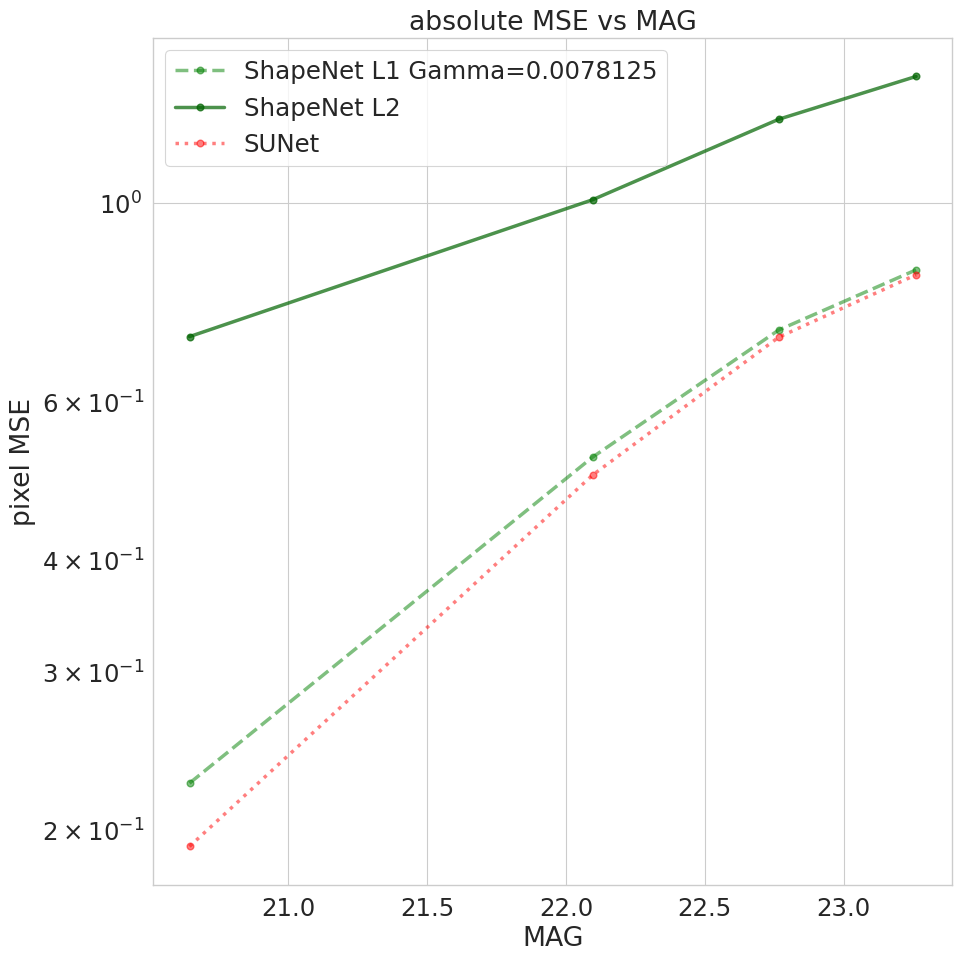

/home/acoundexist/.conda/envs/ShapeNetL1/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


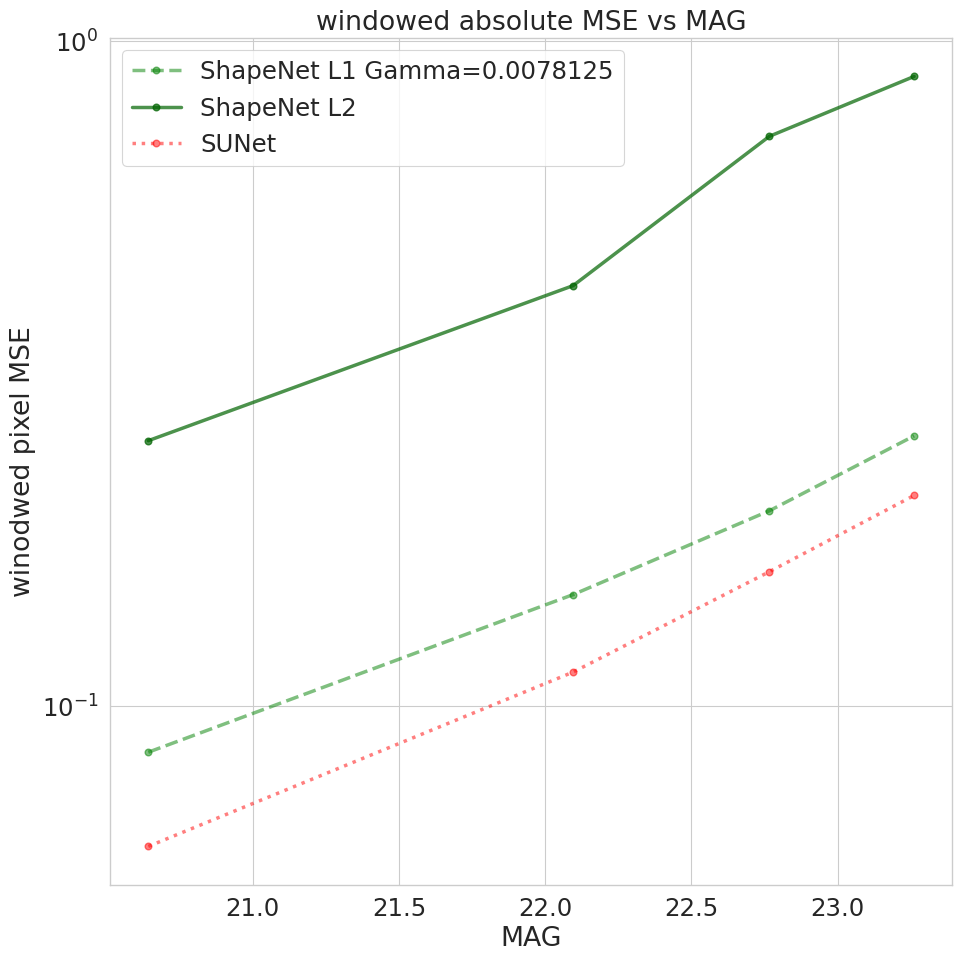

In [43]:
plt.figure(figsize=(10,10))
plt.semilogy(bins,mse_mean_g0,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_SUNet, linestyle=':', marker='o',color=color_SUNet, label=label_SUNet,alpha=0.5)
plt.ylim(bottom=0)

plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.semilogy(bins,mse_mean_g0_w,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_SUNet_w, linestyle=':', marker='o', color=color_SUNet,label=label_SUNet,alpha=0.5)
plt.ylim(bottom=0)

plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

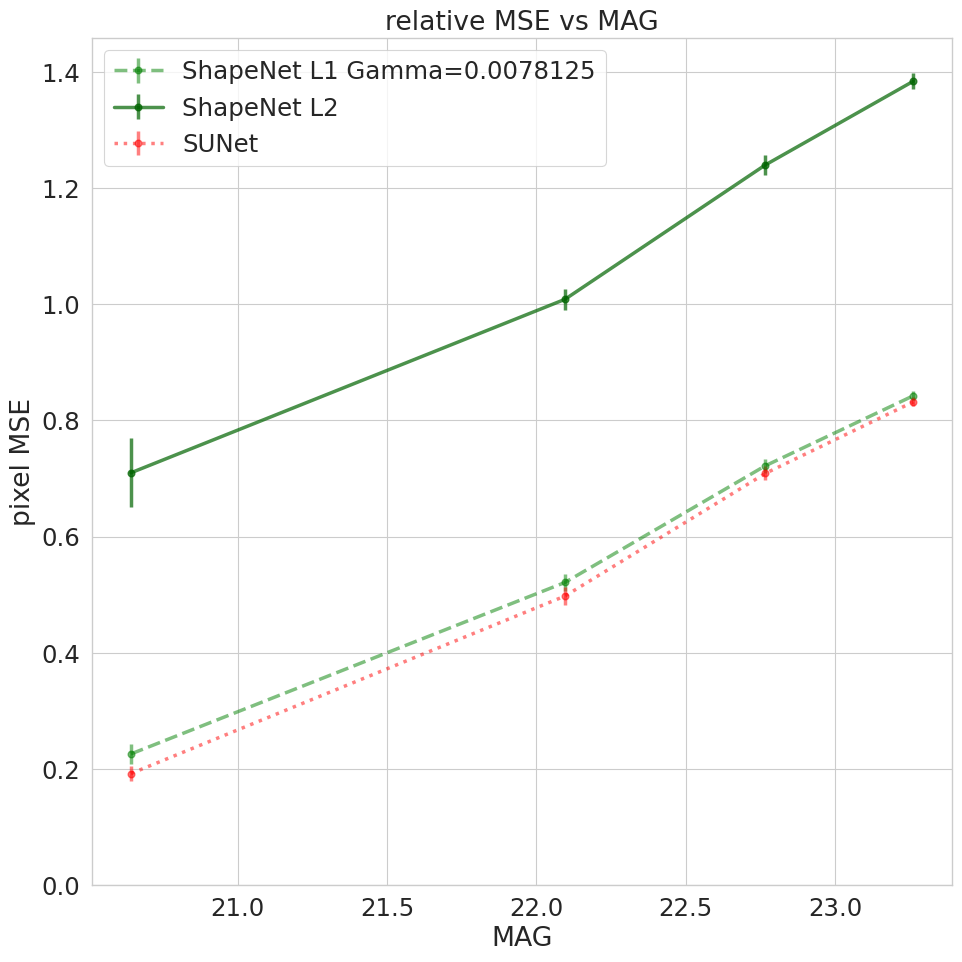

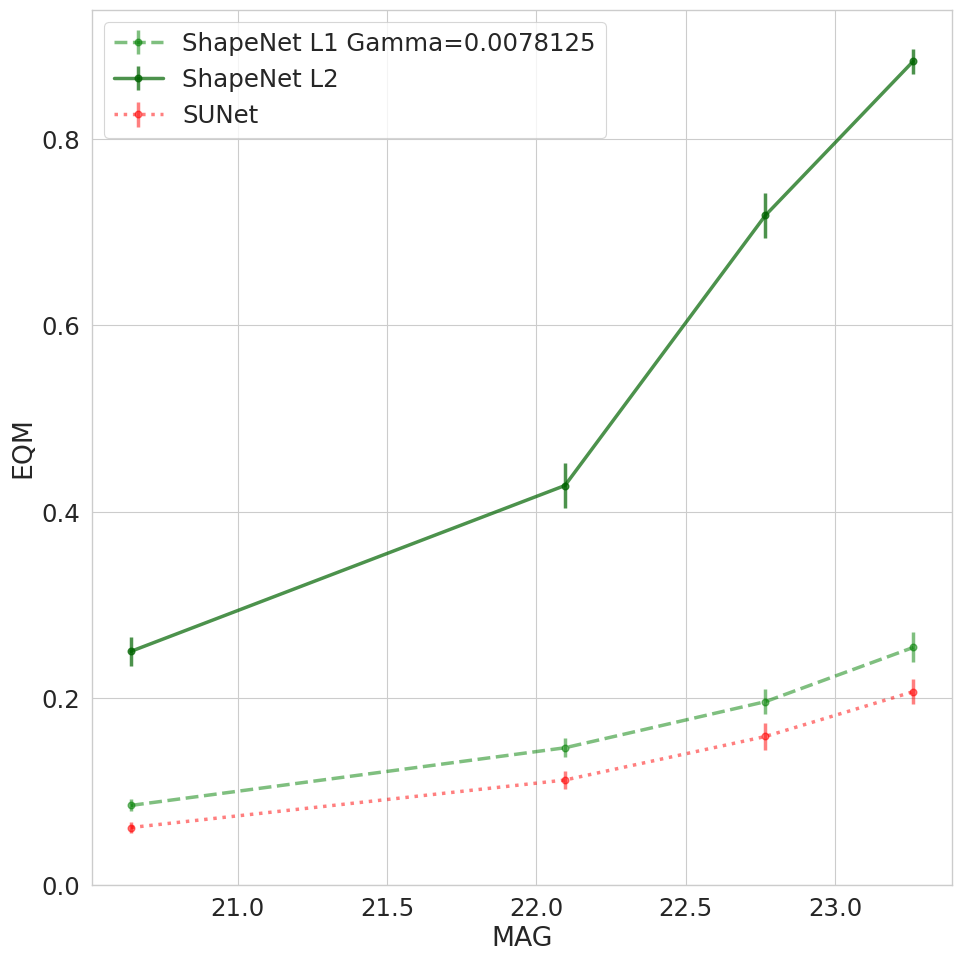

In [44]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mse_mean_SUNet,mse_std_SUNet/sqrt_num_gal,linestyle=':', marker='o', color=color_SUNet, label=label_SUNet, alpha=0.5)
plt.ylim(bottom=0)

plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'relative MSE vs MAG')
plt.legend()
y_min,y_max = plt.ylim()
#y_min = 0.28
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mse_mean_SUNet_w,mse_std_SUNet_w/sqrt_num_gal,linestyle=':',marker='o',color=color_SUNet,label=label_SUNet,alpha=0.5)
plt.ylim(bottom=0)
plt.xlabel(r'MAG')
plt.ylabel(r'EQM')

plt.legend()
y_min,y_max = plt.ylim()
#y_min = 0.1
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.savefig('./cfht_mse.pdf')

### Make Table for Global Performance

In [45]:
n_batch = window_flags.size
sqrt_n_batch = np.sqrt(n_batch)

# compute pixel errors
mse_g0_mean = np.mean(mse_g0_win)
mse_SUNet_mean = np.mean(mse_SUNet_win)
mse_g05_mean = np.mean(mse_g05_win)

mse_g0_std = np.std(mse_g0_win)/sqrt_n_batch
mse_SUNet_std = np.std(mse_SUNet_win)/sqrt_n_batch
mse_g05_std = np.std(mse_g05_win)/sqrt_n_batch

# compute winodwed relative pixel errors
mse_w_g0_mean = np.mean(mse_g0_win_w)
mse_w_SUNet_mean = np.mean(mse_SUNet_win_w)
mse_w_g05_mean = np.mean(mse_g05_win_w)

mse_w_g0_std = np.std(mse_g0_win_w)/sqrt_n_batch
mse_w_SUNet_std = np.std(mse_SUNet_win_w)/sqrt_n_batch
mse_w_g05_std = np.std(mse_g05_win_w)/sqrt_n_batch

# compute adapative moments errors
mom1_err_g0_mean = np.mean(mom_err_g0_win[0])
mom1_err_SUNet_mean = np.mean(mom_err_SUNet_win[0])
mom1_err_g05_mean = np.mean(mom_err_g05_win[0])

mom1_err_g0_std = np.std(mom_err_g0_win[0])/sqrt_n_batch
mom1_err_SUNet_std = np.std(mom_err_SUNet_win[0]/sqrt_n_batch)
mom1_err_g05_std = np.std(mom_err_g05_win[0])/sqrt_n_batch

mom2_err_g0_mean = np.mean(mom_err_g0_win[1])
mom2_err_SUNet_mean = np.mean(mom_err_SUNet_win[1])
mom2_err_g05_mean = np.mean(mom_err_g05_win[1])

mom2_err_g0_std = np.std(mom_err_g0_win[1])/sqrt_n_batch
mom2_err_SUNet_std = np.std(mom_err_SUNet_win[1]/sqrt_n_batch)
mom2_err_g05_std = np.std(mom_err_g05_win[1])/sqrt_n_batch

# compute fluxipticity errors
flux_err_g0_mean = np.mean(np.abs(flux_err_g0_win))
flux_err_SUNet_mean = np.mean(np.abs(flux_err_SUNet_win))
flux_err_g05_mean = np.mean(np.abs(flux_err_g05_win))

flux_err_g0_std = np.std(np.abs(flux_err_g0_win))/sqrt_n_batch
flux_err_SUNet_std = np.std(np.abs(flux_err_SUNet_win))/sqrt_n_batch
flux_err_g05_std = np.std(np.abs(flux_err_g05_win))/sqrt_n_batch

In [46]:
def draw_table(text_list):
    part1 = """\\begin{table}[h!]
\\resizebox{\\textwidth}{!}{
\\begin{tabular}{|l||l|l|l|l|}
\hline
"""
    part1 = ''
    part2 = """{0} & {1}  & {2} & {3} & {4} \\\ \hline
{5} & {6}  & {7} & {8} & {9} \\\\
{10} & {11}  & {12} & {13} & {14} \\\\
{15} & {16}  & {17} & {18} & {19} \\\\ \hline
""".format(*text_list)
    
    part3 = """\end{tabular}
}
\end{table}"""
    part3 = ''
    
    return part1+part2+part3
    
def latex_float(f):
    float_str = "{:.2e}".format(f)
    base, exponent = float_str.split("e")
    base = list(base)
    base[1] = ','
    base = "".join(base)
    return r"{0} . 10^{{{1}}}".format(base, int(exponent))

def latex_float_err(value,err):
    return r'{0} \pm {1}'.format(latex_float(value),latex_float(err))

In [47]:
header = ["Metric", 'MSE', 'flux', 'e_1', 'e_2']
methods = ['ShapeNetL2', 'ShapeNetL1', 'SUNet']

#g05 = ShapeNet
#g0 = ShapeNetL1
#SUNet

means = [mse_w_g05_mean, mse_w_g0_mean, mse_w_SUNet_mean,
        flux_err_g05_mean, flux_err_g0_mean, flux_err_SUNet_mean,
        mom1_err_g05_mean, mom1_err_g0_mean, mom1_err_SUNet_mean,
        mom2_err_g05_mean, mom2_err_g0_mean, mom2_err_SUNet_mean]

stds = [mse_w_g05_std, mse_w_g0_std, mse_w_SUNet_std,
       flux_err_g05_std, flux_err_g0_std, flux_err_SUNet_std,
       mom1_err_g05_std, mom1_err_g0_std, mom1_err_SUNet_std,
       mom2_err_g05_std, mom2_err_g0_std, mom2_err_SUNet_std]

text_list = header + []

for ind,method in enumerate(methods):
    text_list += [method]
    #print(method)
    for j in range(4):
        #print(j)
        text_list += [latex_float_err(means[3*j+ind],stds[3*j+ind])]

print(draw_table(text_list))

Metric & MSE  & flux & e_1 & e_2 \\ \hline
ShapeNetL2 & 5,70 . 10^{-1} \pm 1,19 . 10^{-2}  & 3,76 . 10^{-1} \pm 3,27 . 10^{-2} & 1,52 . 10^{-1} \pm 4,96 . 10^{-3} & 1,84 . 10^{-1} \pm 6,01 . 10^{-3} \\
ShapeNetL1 & 1,71 . 10^{-1} \pm 5,29 . 10^{-3}  & 2,65 . 10^{-1} \pm 2,42 . 10^{-2} & 1,02 . 10^{-1} \pm 3,30 . 10^{-3} & 1,30 . 10^{-1} \pm 4,20 . 10^{-3} \\
SUNet & 1,35 . 10^{-1} \pm 4,98 . 10^{-3}  & 2,54 . 10^{-1} \pm 2,53 . 10^{-2} & 8,98 . 10^{-2} \pm 3,11 . 10^{-3} & 1,07 . 10^{-1} \pm 3,73 . 10^{-3} \\ \hline

